In [17]:
import cdt
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from causalgraphicalmodels import StructuralCausalModel
from cdt.data import load_dataset

In [2]:
columns = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']

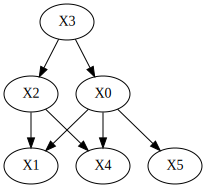

In [3]:
graph_G = StructuralCausalModel({
    "X3": lambda n_samples: np.random.uniform(size=n_samples),
    "X0": lambda X3, n_samples: 3.0 * X3 + np.random.uniform(size=n_samples),
    "X2": lambda X3, n_samples: 6.0 * X3 + np.random.uniform(size=n_samples),
    "X1": lambda X0, X2, n_samples: 3.0 * X0 + 2.0 * X2 + np.random.uniform(size=n_samples),
    "X5": lambda X0, n_samples: 4.0 * X0 + np.random.uniform(size=n_samples),
    "X4": lambda X0, X2, n_samples: 8.0 * X0 - 1.0 * X2 + np.random.uniform(size=n_samples)
})

graph_G.cgm.draw()

In [4]:
X = graph_G.sample(1000)
X = X[columns]

In [10]:
bnl = cdt.causality.graph.bnlearn.GS()
output = bnl.predict(X)

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

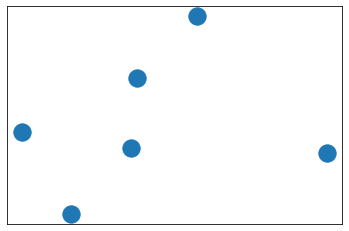

In [18]:
nx.draw_networkx(output)